In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
from model.config import cfg
from model.test import im_detect
from model.nms_wrapper import nms

from utils.timer import Timer
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import argparse

from nets.vgg16 import vgg16
from nets.resnet_v1 import resnetv1


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0)

In [9]:
CLASSES = ('__background__',
           'h')

def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im = cv2.imread(image_name)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)

2
Loaded network ../output/vgg16/14930014888130.5339999847683952/default/vgg16_faster_rcnn_iter_200000.ckpt
Detection took 0.197s for 300 object proposals


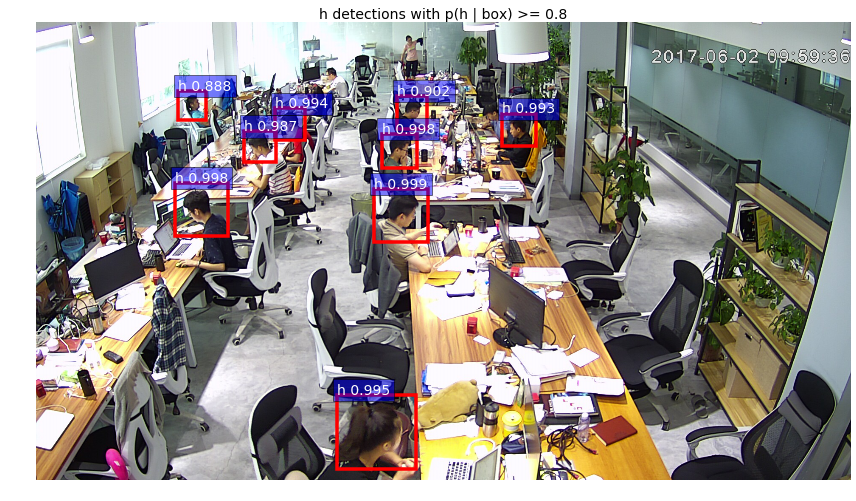

In [13]:
if True:
    os.environ['CUDA_VISIBLE_DEVICES'] = '3'
    cfg.TEST.HAS_RPN = True  # Use RPN for proposals


    # model path
    demonet = 'vgg16'
    tfmodel = '../output/vgg16/14930014888130.5339999847683952/default/vgg16_faster_rcnn_iter_200000.ckpt'


    if not os.path.isfile(tfmodel + '.meta'):
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(tfmodel + '.meta'))

    # set config
    tfconfig = tf.ConfigProto(allow_soft_placement=True)
    tfconfig.gpu_options.allow_growth=True

    # init session
    sess = tf.Session(config=tfconfig)
    # load network
    if demonet == 'vgg16':
        net = vgg16(batch_size=1)
    elif demonet == 'res101':
        net = resnetv1(batch_size=1, num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(sess, "TEST", 2,
                          tag='default', anchor_scales=[8, 16, 32])
    saver = tf.train.Saver()
    saver.restore(sess, tfmodel)

    print('Loaded network {:s}'.format(tfmodel))

    demo(sess, net, '/world/data-c22/Training-data/yrw/5928eaabb63dac80f63f4861/2017-06-02/14963687975860.6329468839829948.jpg')

    plt.show()